<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
REGRESION LINEAL</p><br>

Objetivo:
- Predecir la frecuencia de uso semanal de **UNA ESTACIÓN** , usando como referencia los datos del  **AÑO 2018**.

In [1]:
#funciones y clases particulares al caso de estudio
from localpacks.data import get_data

#datasets
import numpy as np
import pandas as pd

#graficos
import matplotlib.pyplot as plt
import seaborn as sns

## Importamos nuestro df

In [44]:
df_get = get_data(year=2018, apply_format=True) #obtenemos nuestro df con el formato adecuado

In [245]:
df = df_get.copy() #hacemos una copia, para hacer pruebas rapidas, luego esta línea puede ser borrada

In [246]:
df.head(3)

,usuario_id,origen_nombre,origen_id,destino_nombre,destino_id,usuario_genero,usario_edad,tiempo_uso(s)
bici_fecha_hora_retiro,,,,,,,,
2018-01-01 00:08:05,5453,Uruguay,45,Virrey Cevallos,183,M,45,1193
2018-01-01 00:18:05,673,Posadas,189,Guardia Vieja,110,M,61,1579
2018-01-01 00:20:14,179119,Hospital Rivadavia,50,Padilla,31,F,52,1659


#### 1. Escogemos una estación

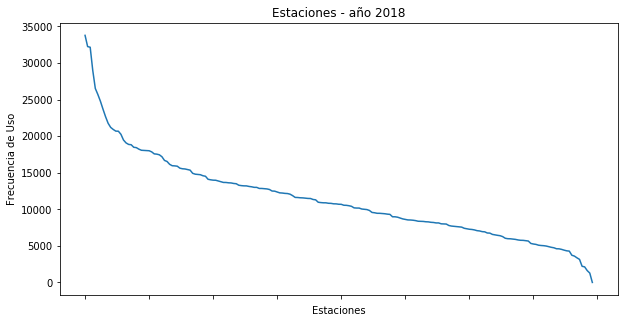

In [247]:
#df['origen_id'].value_counts().sort_values(ascending=False).plot() chequear, ¿porqué el gráfico se vpe distinto?

df['origen_nombre'].value_counts().plot(figsize=(10,5))

plt.title('Estaciones - año 2018')
plt.xlabel('Estaciones')
plt.ylabel('Frecuencia de Uso');

In [248]:
df['origen_nombre'].value_counts()[:3] #filtramos las 3 primeras

Facultad de Medicina    33776
Pacífico                32244
Parque Las Heras        32151
Name: origen_nombre, dtype: int64

Podemos observar que `Facultad de Medicina` es la que tiene la **mayor frecuencia de uso**, es la que usaremos como ejemplo.

In [249]:
df = df[df['origen_nombre'] == 'Facultad de Medicina']

In [250]:
df.shape #verificamos

(33776, 8)

#### 2. Escogemos un mes

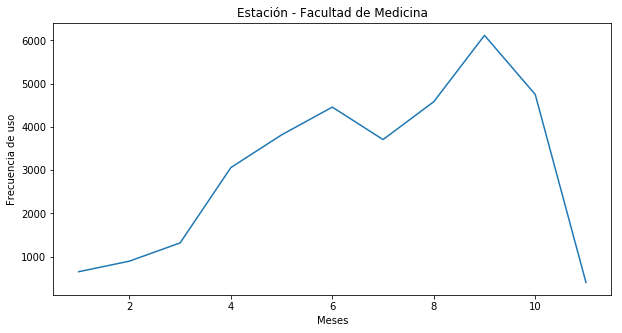

In [251]:
df.groupby(df.index.month)['origen_nombre'].count().plot(figsize=(10,5));
plt.title('Estación - Facultad de Medicina')
plt.ylabel('Frecuencia de uso')
plt.xlabel('Meses');

In [252]:
df.groupby(df.index.month)['origen_nombre'].count().sort_values(ascending=False)[:3]  

bici_fecha_hora_retiro
9     6116
10    4751
8     4583
Name: origen_nombre, dtype: int64

Acorde a nuestro gráfico, el mes de **Septiembre(9)** es el que presenta mayor actividad en la estacion `Facultad de Medicina`.

In [253]:
df = df[df.index.month == 9] #filtramos por mes

In [254]:
df.shape #verificamos

(6116, 8)

#### 3. Derivamos la frecuencia de uso diaria para la estación seleccionada

In [255]:
df = df['origen_nombre'] #dado a que haremos un conteo, solo basta con quedarnos con una columna

In [256]:
group = df.groupby([df.index.month,df.index.day]).count() #contamos los valores, por mes y día

In [257]:
group.unstack(fill_value=0).sum()[:3] #primeros 10 dias 

bici_fecha_hora_retiro
1    106
2     77
3    240
dtype: int64

In [258]:
group = group.unstack(fill_value=0).sum()

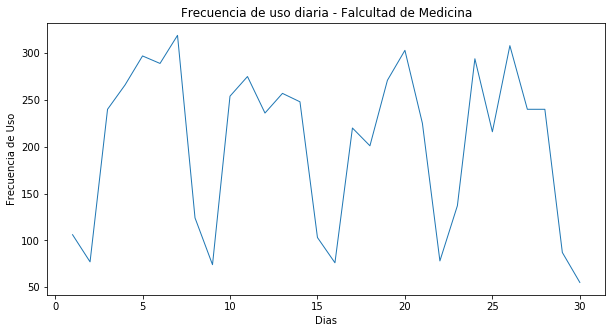

In [262]:
plt.figure(figsize=(10, 5))

#xticks =  pd.period_range(start='2018-09-01', end='2018-09-30', freq='D')
#plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(group, linewidth=1)

plt.title('Frecuencia de uso diaria - Falcultad de Medicina')
plt.xlabel("Dias")
plt.ylabel("Frecuencia de Uso");

## Experimental con Pivot

In [ ]:
pivot = df.pivot_table('origen_nombre', index=df.index.month, columns=df.index.hour, aggfunc='count', fill_value=0)

In [ ]:
pivot = df.pivot_table('origen_nombre', columns=df.index.day, index=df.index.hour, aggfunc='count', fill_value=0)

In [ ]:
pivot.head()

In [ ]:
df.groupby([df.index.month, df.index.day, df.index.hour]).count().unstack()[:1]

### Agregamos el tiempo de uso

In [10]:
df = df[['origen_nombre','tiempo_uso(s)']]